# Disambiguation with non-orthogonal sequences

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix

In [2]:
epsilon = 10e-20

## Create an example with two sequences

In [3]:
def produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r, mixed_start=False, contiguous=True):
    
    n_r = int(r * n_patterns/2)
    n_s = int(s * hypercolumns)
    n_size = int(n_patterns / 2)

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    sequence1 = matrix[:n_size]
    sequence2 = matrix[n_size:]
 
    if mixed_start:
        start_index = 0
        end_index = n_r 
    else:
        start_index = max(int(0.5 * (n_size - n_r)), 0)
        end_index = min(start_index + n_r, n_size)
    
    for index in range(start_index, end_index):
        if contiguous:
            sequence2[index, :n_s] = sequence1[index, :n_s]
        else:
            sequence2[index, ...] = sequence1[index, ...]
            sequence2[index, n_s:] = n_patterns + index 
        
    if False:
        print(n_r)
        print(n_size)
        print(start_index)
        print(end_index)
           
    return sequence1, sequence2

array([[5, 5, 5],
       [1, 6, 6],
       [2, 7, 7],
       [8, 8, 8],
       [9, 9, 9]])


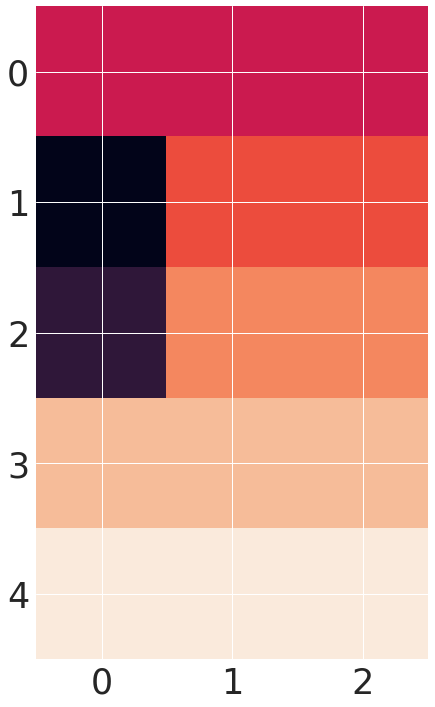

In [4]:
minicolumns = 20
n_patterns = 10
hypercolumns = 3

mixed_start = False
contiguous = True
s = 0.5
r = 0.5

seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r, 
                                         mixed_start=mixed_start, contiguous=contiguous)
pprint.pprint(seq2)
plt.imshow(seq2);

In [5]:
nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

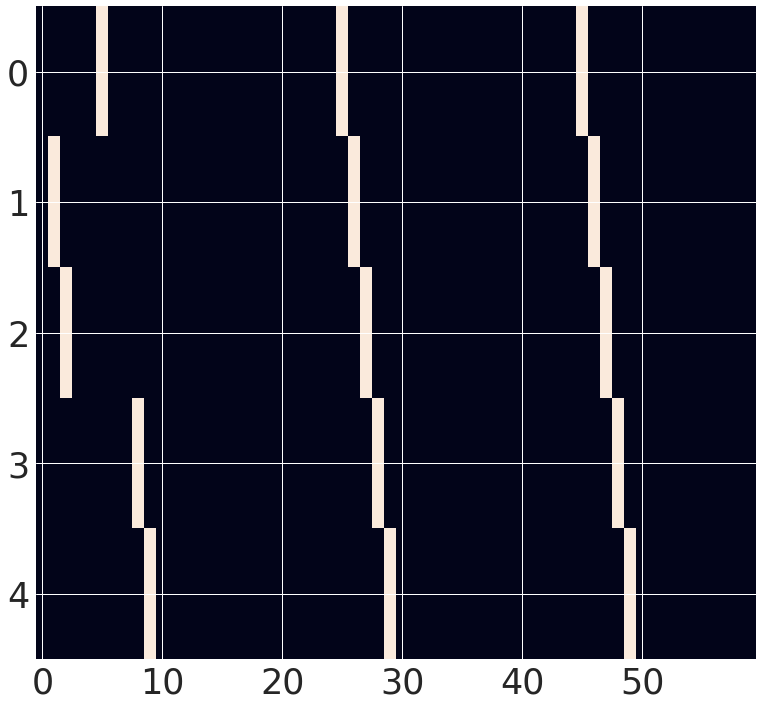

In [6]:
plt.imshow(nr2, aspect='auto')

## An example
Let's make a network that can learn this example

In [7]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 10
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1

# Recall
T_recall = 1.0
n = 1
T_cue = 0.050

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
mixed_start = False
contiguous = True
s = 0.25
r = 0.5

seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r, 
                                         mixed_start=mixed_start, contiguous=contiguous)

nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

In [8]:
filtered = True

# Get the first
timed_input = TimedInput(nr1, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=1)
S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)


pi1, pj1, P1 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
w_timed1 = get_weights_from_probabilities(pi1, pj1, P1, minicolumns, hypercolumns)
t1 = timed_input.T_total

# Get the second
timed_input = TimedInput(nr2, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=1)
S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)
t2 = timed_input.T_total

pi2, pj2, P2 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
w_timed2 = get_weights_from_probabilities(pi2, pj2, P2, minicolumns, hypercolumns)
t_total = t1 + t2

# Mix
pi_total = (t1 / t_total) * pi1 + ((t_total - t1)/ t_total) * pi2
pj_total = (t1 / t_total) * pj1 + ((t_total - t1)/ t_total) * pj2
P_total = (t1 / t_total) * P1 + ((t_total - t1)/ t_total) * P2
w_total, beta = get_weights_from_probabilities(pi_total, pj_total, P_total, minicolumns, hypercolumns)

In [9]:
seq2

array([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       [ 2,  2, 12, 12, 12, 12, 12, 12, 12, 12],
       [ 3,  3, 13, 13, 13, 13, 13, 13, 13, 13],
       [ 4,  4, 14, 14, 14, 14, 14, 14, 14, 14],
       [ 5,  5, 15, 15, 15, 15, 15, 15, 15, 15],
       [ 6,  6, 16, 16, 16, 16, 16, 16, 16, 16],
       [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
       [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]])

In [10]:
seq1

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]])

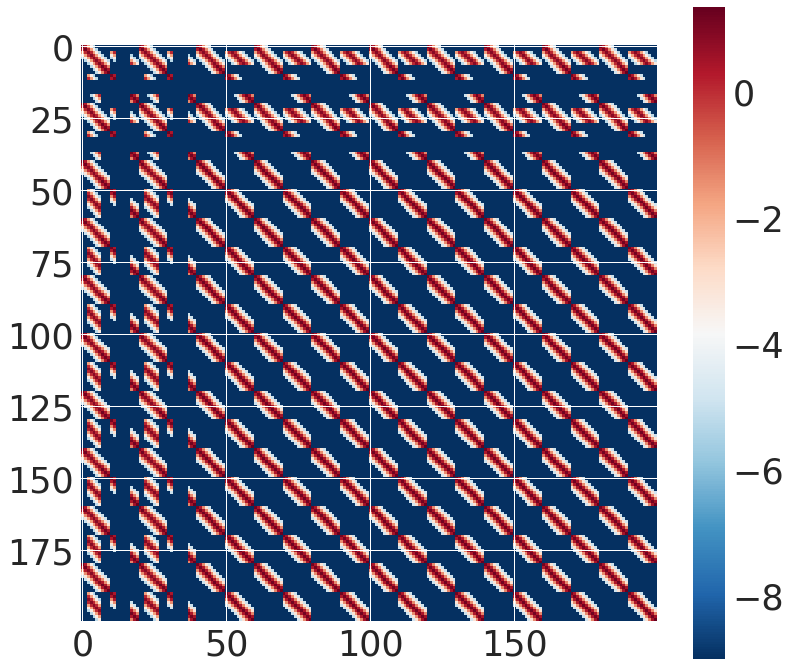

In [11]:
cmap = matplotlib.cm.RdBu_r
plt.imshow(w_total, cmap=cmap)
plt.colorbar();

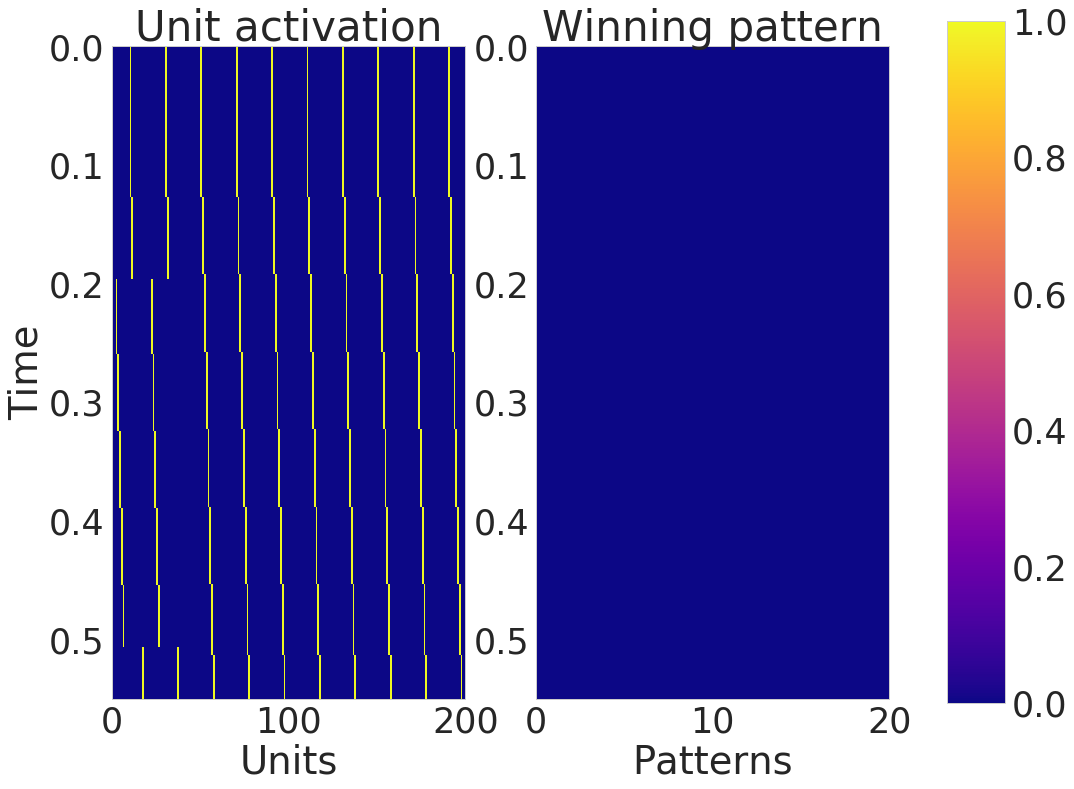

In [12]:
# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
nn.w_ampa = w_total

# Recall
manager.run_network_recall(T_recall=0.50, T_cue=0.050, I_cue=nr2[0], reset=True, empty_history=True)
#manager.run_network_recall(T_recall=0.50, T_cue=0.050, I_cue=nr2[0], reset=False, empty_history=False)

plot_network_activity_angle(manager)

In [13]:
ampa_current = manager.history['i_ampa']
adaptation = manager.history['a']
s = manager.history['s']
o = manager.history['o']

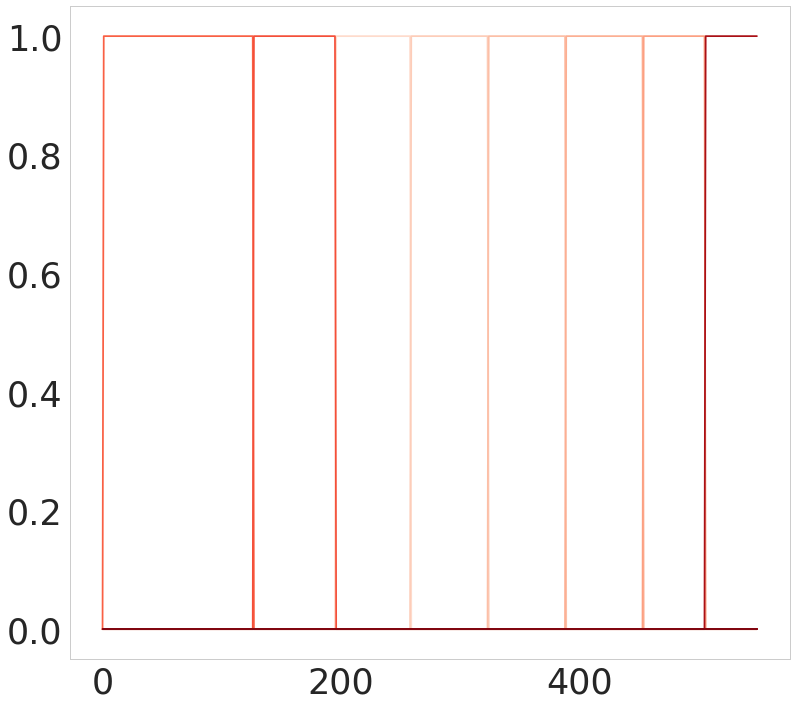

In [14]:
palette = sns.color_palette("Reds", minicolumns)

for index in range(0, minicolumns):
    plt.plot(o[:, index], color=palette[index])
